# Assignment 4 - Blackjack

In [ ]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from collections import deque
import seaborn as sns

Load the gymnasium Blackjack environment. We decided to use the newer version - Gymnasium, as the older on - Gym is soon to be deprecated. Some of the implementations differ a bit but overall the idea is the same, win as much as possible.

In [ ]:
env = gym.make("Blackjack-v1", sab=False)

Here we did a small exploration of the environment, we looked at how one **observation** looks like, the numbers have a meaning:
- observation[0]: int = sum of player's cards
- observation[1]: int = dealers face up card
- observation[2]: bool = usable ace

In [ ]:
observation, info = env.reset()
print(observation)
print("Observation shape:", np.array(observation).shape)

(20, 2, 0)
Observation shape: (3,)


Define a simple policy policy where player sticks (0) whenever the value of his/hers sum of cards is greater or equal to 17, if else then hits.

In [ ]:
def basic_policy(observation):
    return 0 if observation[0] >= 17 else 1

Here we implement the simple policy into a multiple games simulation and print the win rate (note that the win rate differs a bit by each run since we only loop through 1000 games)

In [ ]:
num_games = 1000
wins = 0

#play 1000 games and record the win rate
for _ in range(num_games):
    state, info = env.reset() # get the initial game state
    while True:
        action = basic_policy(state)
        state, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            wins += 1 if reward > 0 else 0
            break

print(f"Win rate :{wins/num_games * 100:.2f}%")

Win rate :39.50%


Next on the menu is **DEEP Q-learning**.

Q - learning is a form of reinforcement learning where an agent learns how to make decisions by interacting with an environment and trying to maximize the reward. It’s a type of reinforcement learning usually used to mimic how children or animals learn.

The approach is

First,  we collect the **sum** of discounted rewards over a period of iterations given a pair of state and action.  Our discount (or **gamma**) being  set to 0.99 means it’s focused on long-term beneficial actions over short term gains.

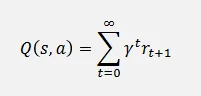


We apply the Bellman equation and add a learning rate which determines how much new information overrides the old Q-value. The other new variable is the discounted maximum Q-value for the next state s′, across all possible actions a′  which is added to the immediate reward given a pair of state & action.

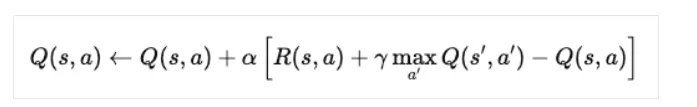

In the context of our Blackjack agent, this equation updates the Q-value based on the immediate reward (e.g., winning or losing a hand) and the maximum expected future rewards (the potential outcomes of hitting or sticking). By repeatedly applying this update during different iterations, the agent learns to approximate the optimal Q-values for different hand values and situations. This enables the agent to determine when to ask for more cards (hit) and when to stick with the given card value (stick) to maximize its long-term rewards (overall winnings).


To sum it up, we define an Agent, which:
- can memorize previous state-action-reward relations
- has a neural netowrk which can be trained on the memorized relations
- can update the neural network
- can choose which action to take based on an epsilon-greedy principle (to maximize exploration and exploitation states)

Then we train the agent on multiple games and visualize the results

In [ ]:
class BlackjackAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
        self.state_size = state_size #3 = (player's sum, dealer's card, usable ace)
        self.action_size = action_size #2 = stick, hit
        self.discount_factor = discount_factor #Future reward discount factor
        self.epsilon = epsilon  #Exploration rate
        self.epsilon_decay = epsilon_decay #Exploration decay rate - the higher, the faster the agent shifts from exploration to exploitation
        self.min_epsilon = min_epsilon #Minimum exploration rate
        self.learning_rate = learning_rate #Learning rate for optimizer
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size) #A fixed number of experience replays (when over, the oldest is removed)

        self.q_network = self.build_model()

    def build_model(self):
        """Q-value network that is replacing the Q-table.
        This model is what 'stores' (in it neurons) the information about what action to take at which state."""
        model = Sequential()

        model.add(Dense(128, input_dim=self.state_size, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dense(32, activation='relu'))
        model.add(BatchNormalization())

        model.add(Dropout(0.5))
        model.add(Dense(self.action_size, activation='linear'))  # Output layer - Q-values for each action

        loss = Huber(delta = 0.7) # Combination of MSE and MAE - basically reduces the error in larger errors to take exploration into consideration
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss=loss)
        return model

    def remember(self, state, action, reward, next_state, done):
      """Saves state-action-reward relations into the memory"""
      self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
      """Chooses whether to explore or exploit (epsilon-greedy policy)"""
      if np.random.rand() < self.epsilon:
          return random.randrange(self.action_size)
      state = np.expand_dims(state, axis=0)
      q_values = self.q_network.predict(state, verbose=0)
      return np.argmax(q_values[0])

    def train_from_replay(self):
        """Uses memory to train the Q-network (model), stabilizing the learning process by using a random sample of past experiences.
        The target represents the expected return for a given state-action pair, helping the network to learn the optimal policy."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state for state, _, _, _, _ in minibatch])
        next_states = np.array([next_state for _, _, _, next_state, _ in minibatch])
        targets = self.q_network.predict(states, verbose=0)
        next_targets = self.q_network.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward if done else reward + self.discount_factor * np.max(next_targets[i])
            targets[i][action] = target

        self.q_network.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay



In [ ]:
def train_agent(episodes=1000, update_target_frequency=10, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
    """Plays certain number of games and trains the agent. Trying to reach the 'optimal' policy"""
    env = gym.make('Blackjack-v1', sab=True)
    state_size = 3  # (player's sum, dealer's card, usable ace)
    action_size = env.action_space.n  # stick (0) or hit (1)
    agent = BlackjackAgent(state_size, action_size, learning_rate, discount_factor, epsilon, epsilon_decay, min_epsilon, memory_size, batch_size)
    win_count = 0

    win_rates = []

    for episode in range(episodes):
        state, _ = env.reset() # Inital state
        state = np.array(state, dtype=np.float32)
        done = False
        total_reward = 0

        # Playing one game
        while not done:
            action = agent.choose_action(state) # Select the action based on game's state
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)

            if terminated or truncated:
                done = True

            agent.remember(state, action, reward, next_state, done) #remember the relations
            state = next_state
            total_reward += reward

        if total_reward > 0:
            win_count += 1

        if len(agent.memory) > batch_size:
          agent.train_from_replay() # train the agent from the games in his memory

        #print win rate stats every 50 games
        if (episode + 1) % 100 == 0:
            win_rate = win_count / (episode + 1)
            win_rates.append(win_rate)
            print(f"Episode {episode + 1}, Win Rate: {win_rate:.2f}, Epsilon: {agent.epsilon:.2f}")


    return agent, win_rates

In [ ]:
def visualize_dqn_results(agent, win_rates):
    # Plot win rate over episodes
    plt.figure(figsize=(12, 5))
    plt.plot(range(100, len(win_rates) * 100 + 1, 100), win_rates, label='Win Rate')
    plt.xlabel('Episodes')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Over Time')
    plt.legend()
    plt.show()

In [ ]:
agent, win_rates = train_agent(episodes=1000, learning_rate=0.001, batch_size=64, discount_factor=0.9, epsilon_decay=0.995)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 100, Win Rate: 0.21, Epsilon: 0.76
Episode 200, Win Rate: 0.27, Epsilon: 0.46
Episode 300, Win Rate: 0.31, Epsilon: 0.28
Episode 400, Win Rate: 0.31, Epsilon: 0.17
Episode 500, Win Rate: 0.33, Epsilon: 0.10
Episode 600, Win Rate: 0.34, Epsilon: 0.06
Episode 700, Win Rate: 0.35, Epsilon: 0.04
Episode 800, Win Rate: 0.36, Epsilon: 0.02
Episode 900, Win Rate: 0.37, Epsilon: 0.01
Episode 1000, Win Rate: 0.38, Epsilon: 0.01


We played around with the hyperparameters but they did not seem to have such an effect in this case, as we believe that the main factor is the number of games (episodes played) and 1000 is a relative small number in the would of reinforcement learning. So the main steps for trying to improve the model would be to just give it more time to learn.

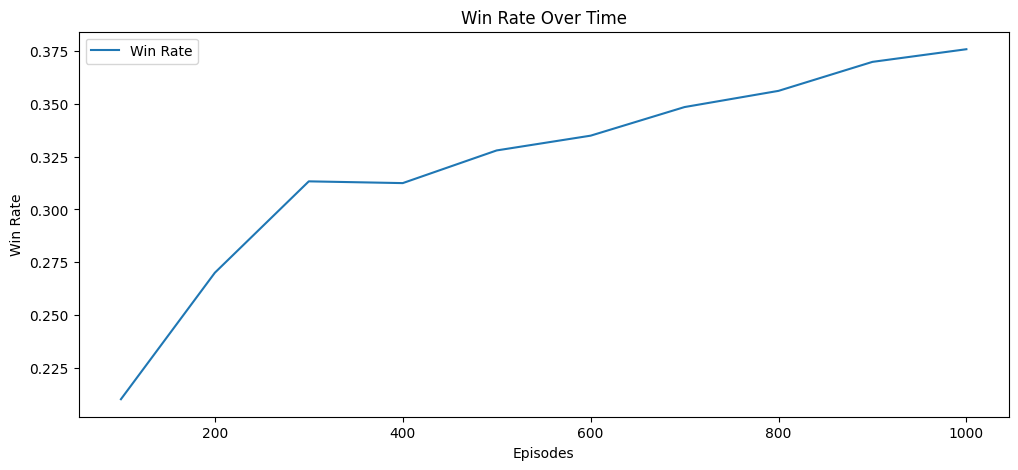

In [ ]:
visualize_dqn_results(agent, win_rates)

Description of Heatmap Colors:
Positive Values (Red): Indicate that the Q-value for 'Hit' is higher than the Q-value for 'Stick'. The agent is more likely to choose 'Hit' in these states.
Negative Values (Blue): Indicate that the Q-value for 'Stick' is higher than the Q-value for 'Hit'. The agent is more likely to choose 'Stick' in these states.


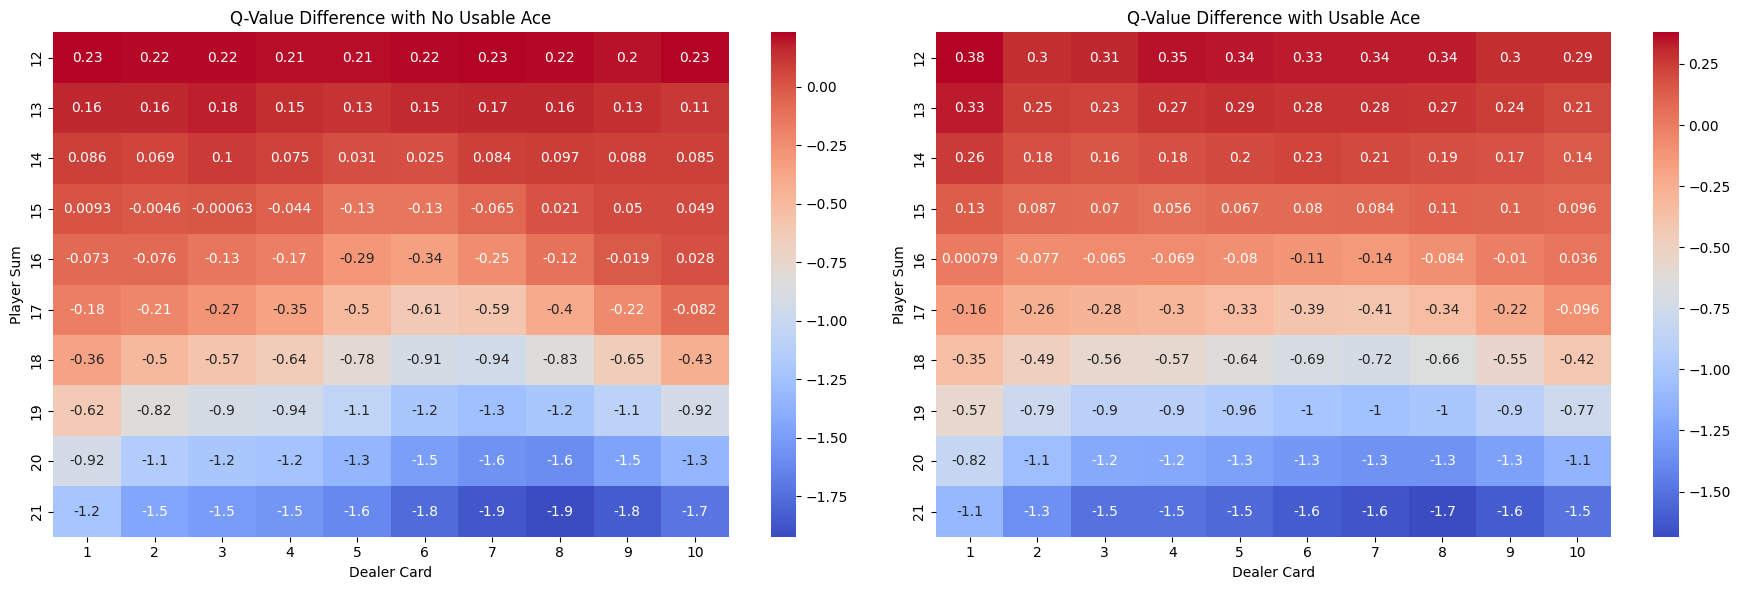

In [ ]:
def visualize_q_values(agent):
    player_sum = np.arange(12, 22)
    dealer_card = np.arange(1, 11)
    usable_ace = [0, 1]

    q_values = np.zeros((len(player_sum), len(dealer_card), len(usable_ace), 2))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_card):
            for k, ace in enumerate(usable_ace):
                state = np.array([player, dealer, ace], dtype=np.float32)
                q_values[i, j, k] = agent.q_network.predict(np.expand_dims(state, axis=0), verbose=0)[0]

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    for k, ace in enumerate(usable_ace):
        ax = axes[k]
        Z = q_values[:, :, k, 1] - q_values[:, :, k, 0]  # Difference between 'Hit' and 'Stick' Q-values
        sns.heatmap(Z, xticklabels=dealer_card, yticklabels=player_sum, cmap='coolwarm', ax=ax, annot=True)
        ax.set_title(f'Q-Value Difference with {"Usable" if ace else "No Usable"} Ace')
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Sum')

    plt.tight_layout()
    plt.show()

# Description of heatmap colors
print("Description of Heatmap Colors:")
print("Positive Values (Red): Indicate that the Q-value for 'Hit' is higher than the Q-value for 'Stick'. The agent is more likely to choose 'Hit' in these states.")
print("Negative Values (Blue): Indicate that the Q-value for 'Stick' is higher than the Q-value for 'Hit'. The agent is more likely to choose 'Stick' in these states.")

visualize_q_values(agent)

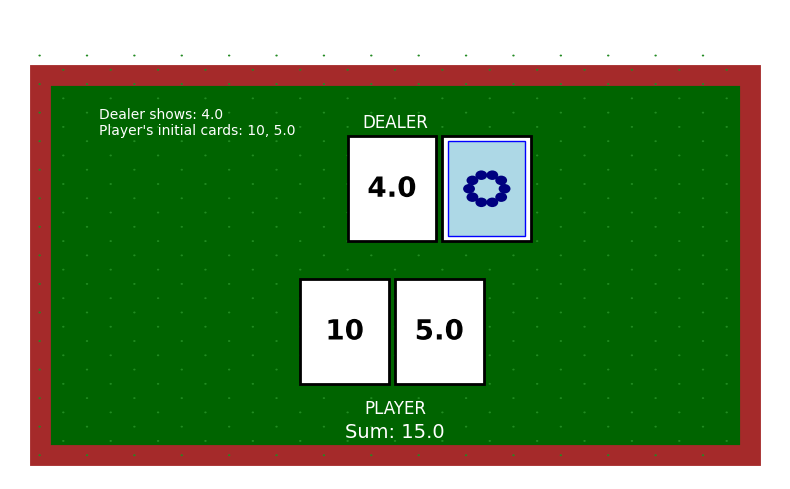

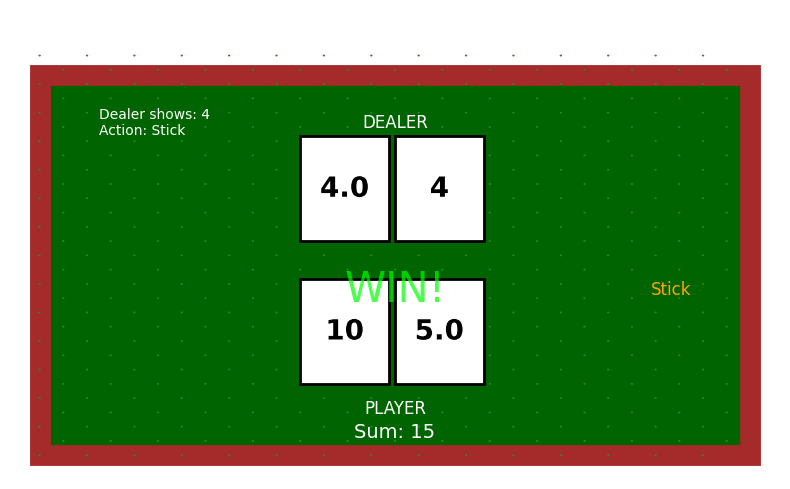

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib.patheffects import withStroke
import numpy as np

def create_card(ax, x, y, value=None, hidden=False):
    # Create card background
    card = Rectangle((x, y), 1.5, 2.2, facecolor='white', edgecolor='black', linewidth=2)
    ax.add_patch(card)

    if hidden:
        # Create card back design
        ax.add_patch(Rectangle((x+0.1, y+0.1), 1.3, 2, facecolor='lightblue', edgecolor='blue'))
        for i in range(10):
            ax.add_patch(Circle((x+0.75+0.3*np.cos(i*np.pi/5), y+1.1+0.3*np.sin(i*np.pi/5)),
                              0.1, facecolor='navy'))
    elif value is not None:
        # Add card value
        if value == 1:
            value = 'A'
        elif value == 11:
            value = 'J'
        elif value == 12:
            value = 'Q'
        elif value == 13:
            value = 'K'
        else:
            value = str(value)
        plt.text(x+0.75, y+1.1, value, ha='center', va='center',
                fontsize=20, fontweight='bold',
                path_effects=[withStroke(linewidth=3, foreground='white')])

def create_card(ax, x, y, value=None, hidden=False):
    # Create card background
    card = Rectangle((x, y), 1.5, 2.2, facecolor='white', edgecolor='black', linewidth=2)
    ax.add_patch(card)

    if hidden:
        # Create card back design
        ax.add_patch(Rectangle((x+0.1, y+0.1), 1.3, 2, facecolor='lightblue', edgecolor='blue'))
        for i in range(10):
            ax.add_patch(Circle((x+0.75+0.3*np.cos(i*np.pi/5), y+1.1+0.3*np.sin(i*np.pi/5)),
                              0.1, facecolor='navy'))
    elif value is not None:
        # Add card value
        display_value = value
        if value == 1:  # Special handling for Ace
            display_value = 'A'
            # Add small numbers for possible values
            plt.text(x+0.3, y+0.3, "1", ha='center', va='center',
                    fontsize=12, fontweight='bold', color='red')
            plt.text(x+1.2, y+1.9, "11", ha='center', va='center',
                    fontsize=12, fontweight='bold', color='red')
        elif value == 11:
            display_value = 'J'
        elif value == 12:
            display_value = 'Q'
        elif value == 13:
            display_value = 'K'
        else:
            display_value = str(value)

        plt.text(x+0.75, y+1.1, display_value, ha='center', va='center',
                fontsize=20, fontweight='bold',
                path_effects=[withStroke(linewidth=3, foreground='white')])

def play_blackjack(agent):
    env = gym.make('Blackjack-v1', sab=True)
    state, info = env.reset()
    state = np.array(state, dtype=np.float32)
    done = False
    game_states = []

    # Record initial state - player already has 2 cards at start
    initial_cards = []
    # Deduce minimum cards needed for sum
    if state[0] >= 12 and not state[2]:  # If sum >= 12 and no usable ace
        initial_cards = [10, state[0] - 10]  # Assume a 10 and the remainder
    elif state[2]:  # If there's a usable ace (counting as 11)
        initial_cards = [1, state[0] - 11]  # Ace + remainder
    else:  # For sums < 12
        initial_cards = [state[0] - 2, 2]  # Simple split

    game_states.append({
        'player_sum': state[0],
        'dealer_cards': [state[1]],
        'usable_ace': bool(state[2]),
        'player_cards': initial_cards,  # Add initial cards
        'action': None,
        'reward': None
    })

    while not done:
        action = agent.choose_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        if done:
            dealer_cards = game_states[-1]['dealer_cards'] + [next_state[1]]
        else:
            dealer_cards = game_states[-1]['dealer_cards']

        # For subsequent states, track the new card if it's a hit
        player_cards = game_states[-1]['player_cards'].copy()
        if action == 1 and not done:  # If Hit
            new_card = next_state[0] - state[0]  # Approximate the new card value
            player_cards.append(new_card)

        game_states.append({
            'player_sum': next_state[0],
            'dealer_cards': dealer_cards,
            'usable_ace': bool(next_state[2]),
            'player_cards': player_cards,
            'action': 'Hit' if action == 1 else 'Stick',
            'reward': reward if done else None
        })

        state = next_state

    return game_states

def visualize_game(game_states):
    for i, state in enumerate(game_states):
        fig, ax = plt.subplots(figsize=(8, 5))

        # Create poker table
        table = Rectangle((0, 0), 12, 8, facecolor='darkgreen', edgecolor='brown', linewidth=15)
        ax.add_patch(table)

        # Reduced felt texture
        for x in range(30):
            for y in range(30):
                if (x + y) % 2 == 0:
                    ax.add_patch(Circle((x*0.4, y*0.3), 0.02, facecolor='forestgreen'))

        # Dealer area
        plt.text(6, 7, "DEALER", ha='center', va='center', color='white', fontsize=12)

        # Dealer's cards
        num_dealer_cards = len(state['dealer_cards'])
        dealer_start_x = 6 - (num_dealer_cards * 0.8)

        for j, card in enumerate(state['dealer_cards']):
            create_card(ax, dealer_start_x + (j * 1.6), 4.5, card)

        if state['reward'] is None:
            create_card(ax, dealer_start_x + (len(state['dealer_cards']) * 1.6), 4.5, hidden=True)

        # Player area
        plt.text(6, 1, "PLAYER", ha='center', va='center', color='white', fontsize=12)

        # Player's cards
        num_player_cards = len(state['player_cards'])
        player_start_x = 6 - (num_player_cards * 0.8)
        for j, card in enumerate(state['player_cards']):
            create_card(ax, player_start_x + (j * 1.6), 1.5, card)

        # Show player's sum with ace handling
        if state['usable_ace']:
            sum_text = f"Sum: {state['player_sum']} (Ace=11)"
        else:
            if state['player_sum'] <= 11:
                sum_text = f"Sum: {state['player_sum']} (Ace=1)"
            else:
                sum_text = f"Sum: {state['player_sum']}"

        plt.text(6, 0.5, sum_text, ha='center', va='center', color='white', fontsize=14)

        # State narrative
        narrative = []
        if i == 0:
            card_text = "A(1/11)" if state['dealer_cards'][0] == 1 else str(state['dealer_cards'][0])
            narrative.append(f"Dealer shows: {card_text}")
            narrative.append(f"Player's initial cards: {', '.join(str(c) for c in state['player_cards'])}")
            if state['usable_ace']:
                narrative.append("Ace=11")
        else:
            prev_state = game_states[i-1]
            if len(state['dealer_cards']) > len(prev_state['dealer_cards']):
                new_card = state['dealer_cards'][-1]
                card_text = "A(1/11)" if new_card == 1 else str(new_card)
                narrative.append(f"Dealer shows: {card_text}")
            if state['player_sum'] != prev_state['player_sum']:
                if len(state['player_cards']) > len(prev_state['player_cards']):
                    new_card = state['player_cards'][-1]
                    narrative.append(f"Player draws: {new_card}")
                narrative.append(f"Sum: {prev_state['player_sum']}→{state['player_sum']}")
            if state['action']:
                narrative.append(f"Action: {state['action']}")

        # Display narrative
        plt.text(1, 7, '\n'.join(narrative), ha='left', va='center', color='white', fontsize=10)

        # Show action - centered vertically
        if state['action']:
            action_color = 'yellow' if state['action'] == 'Hit' else 'orange'
            plt.text(11, 3.5, f"{state['action']}", ha='right', va='center',
                    color=action_color, fontsize=12)

        # Show result - centered between cards
        if state['reward'] is not None:
            result = "WIN!" if state['reward'] > 0 else "LOSS!" if state['reward'] < 0 else "DRAW"
            result_color = 'lime' if state['reward'] > 0 else 'red' if state['reward'] < 0 else 'yellow'
            plt.text(6, 3.5, result, ha='center', va='center', color=result_color, fontsize=30, alpha=0.7)

        plt.title(f'State {i+1}', pad=20, color='white', fontsize=12)
        ax.set_xlim(-0.5, 12.5)
        ax.set_ylim(-0.5, 8.5)
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        plt.close()

# Play and visualize a game
game_states = play_blackjack(agent)
visualize_game(game_states)
